# Instalação das dependências

In [ ]:
! pip install yfinance
! pip install tensorflow
! pip install keras
! pip install pystan
! pip install fbprophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, LSTM, Dropout

# Importação e Visualização dos dados

In [ ]:
# Função para carregar e formatar dados de criptomoedas usando yfinance
def load_crypto_data(ticker, start_date):
  # Baixa os dados usando o ticker fornecido e a data de início
  df = yf.download(ticker, start=start_date, end=None)

  # Formatando os dados: converte o índice (Date) em uma coluna separada
  df = df.reset_index()

  # Exibe informações do DataFrame
  df.info()

  return df


In [ ]:
# Importa os dados do Bitcoin desde 1/1/2020 até o presente
btc_df = load_crypto_data('BTC-USD', '2020-01-01')

btc_df.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1734 non-null   datetime64[ns]
 1   Open       1734 non-null   float64       
 2   High       1734 non-null   float64       
 3   Low        1734 non-null   float64       
 4   Close      1734 non-null   float64       
 5   Adj Close  1734 non-null   float64       
 6   Volume     1734 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.0 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [ ]:
# Importa os dados do Ethereum desde 1/1/2020 até o presente
eth_df = load_crypto_data('ETH-USD', '2020-01-01')

eth_df.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1734 non-null   datetime64[ns]
 1   Open       1734 non-null   float64       
 2   High       1734 non-null   float64       
 3   Low        1734 non-null   float64       
 4   Close      1734 non-null   float64       
 5   Adj Close  1734 non-null   float64       
 6   Volume     1734 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 95.0 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330
1,2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256
2,2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358
3,2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515
4,2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353


In [ ]:
# Merge dos dataframes com sufixos para evitar conflitos de nomes de colunas
market_df = pd.merge(btc_df, eth_df, on='Date', suffixes=('_btc', '_eth'))

# Adicionando nova coluna da diferença entre o preço de abertura e fechamento
for coin in ['btc', 'eth']:
    market_df[f'{coin}_day_diff'] = (market_df[f'Close_{coin}'] - market_df[f'Open_{coin}']) / market_df[f'Open_{coin}']

# Filtrando o DataFrame para datas a partir de 2020-01-01
market_df = market_df[market_df['Date'] >= '2020-01-01']

# Exibe as primeiras linhas do DataFrame resultante
market_df.head()

,Date,Open_btc,High_btc,Low_btc,Close_btc,Adj Close_btc,Volume_btc,Open_eth,High_eth,Low_eth,Close_eth,Adj Close_eth,Volume_eth,btc_day_diff,eth_day_diff
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330,0.000734,0.009036
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256,-0.030139,-0.026065
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358,0.051608,0.053060
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515,0.008887,0.006714
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353,0.000117,0.008919


# Exploração dos Dados


## Visualização das Tendências de Preço

O Preço de fechamento das criptomoedas Bitcoin e Ethereum ao longo do tempo para observar suas tendências e flutuações.

Ao visualizar as variações ao longo dos anos, podemos identificar padrões claros de alta ou baixa. Isso pode indicar momentos em que o mercado teve picos de alta ou quedas bruscas, revelando tendências de mercado que podem ser usadas para prever momentos ideais de compra ou venda. Se houver um padrão claro de ciclos, podemos justificar o uso de modelos como Séries Temporais

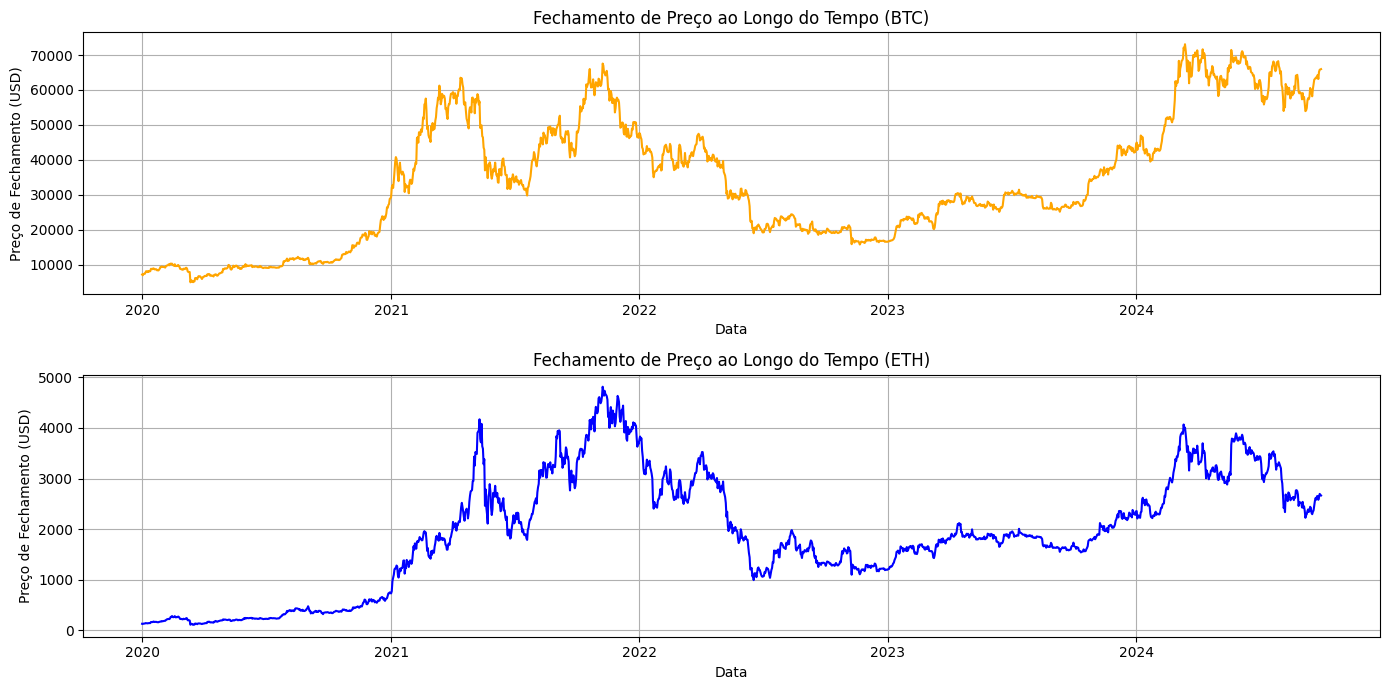

In [ ]:
# Gráfico de preços ao longo do tempo para Bitcoin e Ethereum
plt.figure(figsize=(14, 7))

# Bitcoin
plt.subplot(2, 1, 1)
plt.plot(market_df['Date'], market_df['Close_btc'], label='Bitcoin', color='orange')
plt.title('Fechamento de Preço ao Longo do Tempo (BTC)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)

# Ethereum
plt.subplot(2, 1, 2)
plt.plot(market_df['Date'], market_df['Close_eth'], label='Ethereum', color='blue')
plt.title('Fechamento de Preço ao Longo do Tempo (ETH)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Análise de Volatilidade Diária

A volatilidade diária é calculada como a variação percentual entre o preço de fechamento e o de abertura em cada dia. O que podemos tirar disso? A volatilidade é um fator essencial para análise de risco. Se a volatilidade diária for alta, os ativos são considerados arriscados, mas com grande potencial de retorno. Essa análise ajuda a justificar o uso de modelos que são capazes de lidar com altos níveis de imprevisibilidade, para prever variações rápidas de preço. Identificar dias de alta volatilidade pode indicar momentos críticos para operações de compra ou venda.

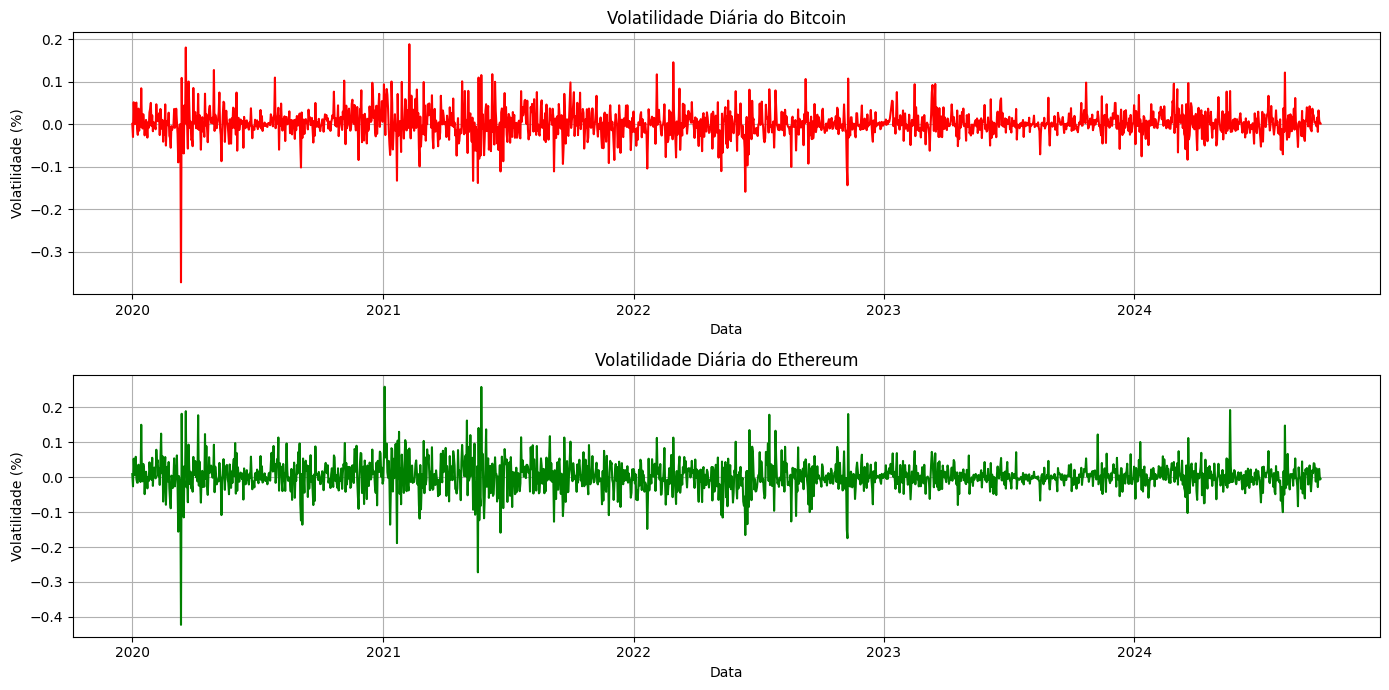

In [ ]:
# Calculando a volatilidade (diferença percentual entre o preço de abertura e fechamento)
market_df['btc_volatility'] = (market_df['Close_btc'] - market_df['Open_btc']) / market_df['Open_btc']
market_df['eth_volatility'] = (market_df['Close_eth'] - market_df['Open_eth']) / market_df['Open_eth']

# Plotando a volatilidade ao longo do tempo
plt.figure(figsize=(14, 7))

# Bitcoin Volatilidade
plt.subplot(2, 1, 1)
plt.plot(market_df['Date'], market_df['btc_volatility'], label='Bitcoin Volatility', color='red')
plt.title('Volatilidade Diária do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.grid(True)

# Ethereum Volatilidade
plt.subplot(2, 1, 2)
plt.plot(market_df['Date'], market_df['eth_volatility'], label='Ethereum Volatility', color='green')
plt.title('Volatilidade Diária do Ethereum')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


## Identificação de Padrões com Média Móvel

Calculamos a média móvel de 30 dias para os preços de fechamento, que suaviza as flutuações diárias e nos ajuda a ver tendências de longo prazo. A média móvel é plotada ao lado dos preços reais de fechamento.

A média móvel é uma ferramenta clássica de análise técnica que ajuda a identificar o início de novas tendências ou reversões de mercado. Se os preços atuais ultrapassarem consistentemente a média móvel, isso pode indicar uma tendência de alta, sugerindo um bom momento para compra. Por outro lado, se o preço estiver abaixo da média móvel, pode ser um sinal de venda. Isso pode justificar o uso de indicadores técnicos no modelo de machine learning para auxiliar na previsão de compras ou vendas futuras.

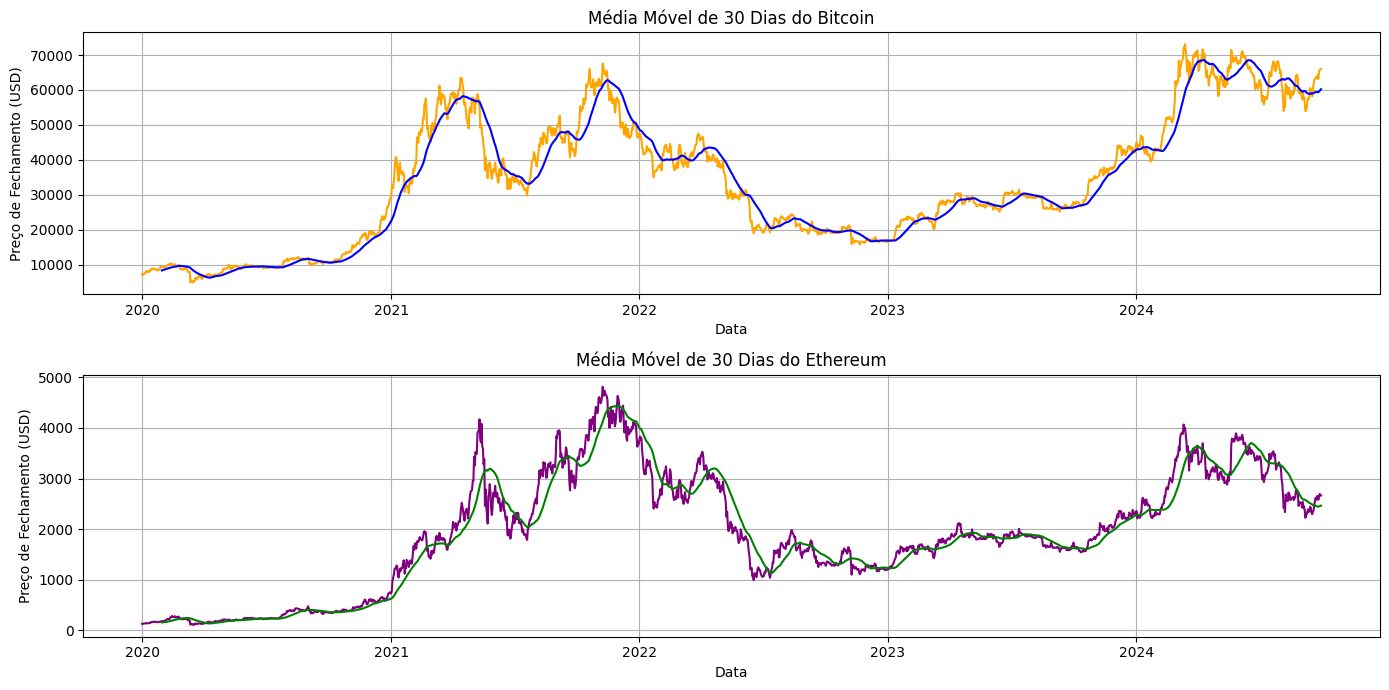

In [ ]:
# Calculando médias móveis de 30 dias para o preço de fechamento
market_df['btc_ma30'] = market_df['Close_btc'].rolling(window=30).mean()
market_df['eth_ma30'] = market_df['Close_eth'].rolling(window=30).mean()

# Gráfico de preços de fechamento e médias móveis
plt.figure(figsize=(14, 7))

# Bitcoin Média Móvel
plt.subplot(2, 1, 1)
plt.plot(market_df['Date'], market_df['Close_btc'], label='Bitcoin Preço de Fechamento', color='orange')
plt.plot(market_df['Date'], market_df['btc_ma30'], label='Bitcoin Média Móvel 30 Dias', color='blue')
plt.title('Média Móvel de 30 Dias do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)

# Ethereum Média Móvel
plt.subplot(2, 1, 2)
plt.plot(market_df['Date'], market_df['Close_eth'], label='Ethereum Preço de Fechamento', color='purple')
plt.plot(market_df['Date'], market_df['eth_ma30'], label='Ethereum Média Móvel 30 Dias', color='green')
plt.title('Média Móvel de 30 Dias do Ethereum')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Autocorrelação dos Preços

Verifica se os preços de um dia estão correlacionados com os dias anteriores. A autocorrelação dos preços sugere que os valores atuais estão fortemente relacionados aos valores dos dias anteriores. Isso significa que há uma dependência temporal significativa nos dados.

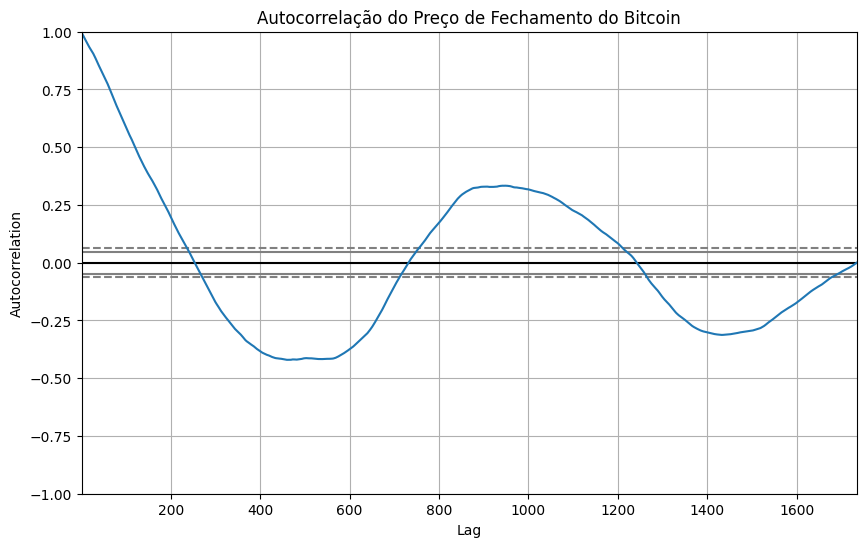

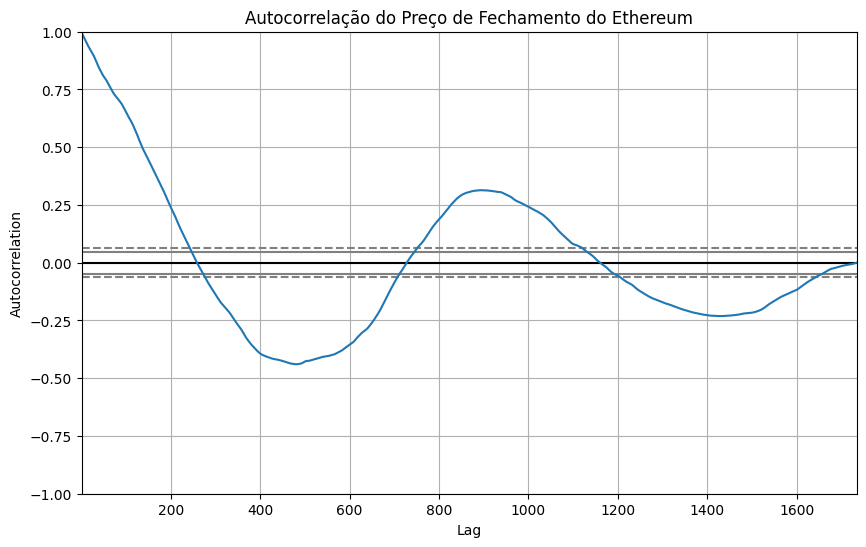

In [ ]:
# Autocorrelação do preço de fechamento do Bitcoin
plt.figure(figsize=(10, 6))
autocorrelation_plot(market_df['Close_btc'])
plt.title('Autocorrelação do Preço de Fechamento do Bitcoin')
plt.show()

# Autocorrelação do preço de fechamento do Ethereum
plt.figure(figsize=(10, 6))
autocorrelation_plot(market_df['Close_eth'])
plt.title('Autocorrelação do Preço de Fechamento do Ethereum')
plt.show()


## Conclusão

Podemos argumentar que, após a análise exploratória, identificamos padrões temporais significativos no comportamento de preços de criptomoedas como Bitcoin e Ethereum. Esses ativos exibem oscilações ao longo do tempo que estão associadas a múltiplos fatores, incluindo tendências de mercado, sazonalidades, volatilidade e eventos específicos do setor.

Dada a natureza dos dados, em que as variáveis-chave — como os preços de abertura, fechamento e volume — são fortemente influenciadas por valores anteriores, fica evidente a importância de se utilizar um modelo de séries temporais para capturar essas dinâmicas. Um modelo temporal pode considerar as dependências de curto e longo prazo, além de lidar com as flutuações inerentes e possíveis sazonalidades presentes nos preços dos ativos.

Isso nos permitirá testar diferentes abordagens, como modelos que capturam tanto padrões lineares quanto não lineares, para prever variações de preço e identificar possíveis oportunidades de compra e venda. Portanto, a escolha de um modelo de série temporal será fundamental para a próxima fase da construção do sistema de apoio à tomada de decisão.

# Treinamento do Modelo

## LSTM

### Dados para teste

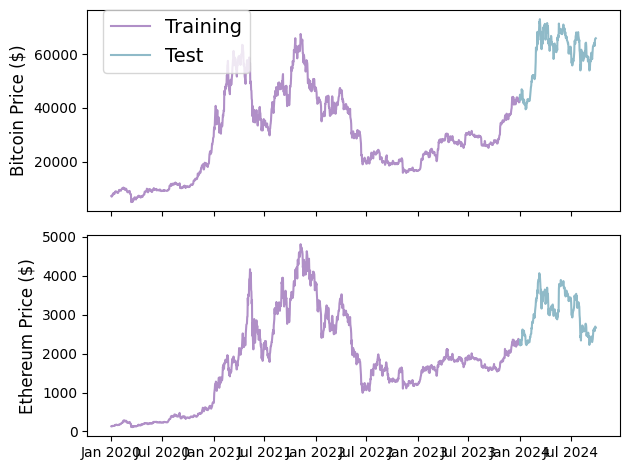

In [ ]:
split_date = '2024-01-01'

# Configuração dos gráficos
fig, (ax1, ax2) = plt.subplots(2, 1)

# Definir ticks nos eixos x para os dois gráficos
ax1.set_xticks([datetime.date(i, j, 1) for i in range(2013, 2025) for j in [1, 7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i, j, 1) for i in range(2013, 2025) for j in [1, 7]])
ax2.set_xticklabels([datetime.date(i, j, 1).strftime('%b %Y') for i in range(2013, 2025) for j in [1, 7]])

# Gráfico para Bitcoin
ax1.plot(pd.to_datetime(market_df[market_df['Date'] < split_date]['Date']),
         market_df[market_df['Date'] < split_date]['Close_btc'],
         color='#B08FC7', label='Training')

ax1.plot(pd.to_datetime(market_df[market_df['Date'] >= split_date]['Date']),
         market_df[market_df['Date'] >= split_date]['Close_btc'],
         color='#8FBAC8', label='Test')

# Gráfico para Ethereum
ax2.plot(pd.to_datetime(market_df[market_df['Date'] < split_date]['Date']),
         market_df[market_df['Date'] < split_date]['Close_eth'],
         color='#B08FC7')

ax2.plot(pd.to_datetime(market_df[market_df['Date'] >= split_date]['Date']),
         market_df[market_df['Date'] >= split_date]['Close_eth'],
         color='#8FBAC8')

# Configuração dos eixos e rótulos
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
ax2.set_ylabel('Ethereum Price ($)', fontsize=12)
plt.tight_layout()

# Legenda do gráfico 1
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})

# Mostrar gráfico
plt.show()

In [ ]:
for coins in ['_btc', '_eth']:
    kwargs = { 'close_off_high'+coins: lambda x: 2*(x['High'+coins]- x['Close'+coins])/(x['High'+coins]-x['Low'+coins])-1,
                'volatility'+coins: lambda x: (x['High'+coins]- x['Low'+coins])/(x['Open'+coins])}
    market_df = market_df.assign(**kwargs)

In [ ]:
model_data = market_df[['Date']+[metric+coin for coin in ['_btc', '_eth']
                                   for metric in ['Close','Volume','close_off_high','volatility']]]

model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,Close_btc,Volume_btc,close_off_high_btc,volatility_btc,Close_eth,Volume_eth,close_off_high_eth,volatility_eth
0,2020-01-01,7200.174316,18565664997,0.364374,0.011034,130.802002,7935230330,0.118129,0.028057
1,2020-01-02,6985.470215,20802083465,0.637394,0.038443,127.410179,8032709256,0.764422,0.029545
2,2020-01-03,7344.884277,28111481032,-0.723969,0.071404,134.171707,10476845358,-0.905181,0.063291
3,2020-01-04,7410.656738,18444271275,-0.716149,0.016047,135.069366,7430904515,-0.347078,0.022451
4,2020-01-05,7411.317383,19725074095,0.850214,0.019427,136.276779,7526675353,0.435842,0.032313


In [ ]:
# Filtra os dados para criar conjuntos de treino e teste
training_set = model_data[model_data['Date'] < split_date]
test_set = model_data[model_data['Date'] >= split_date]

# Remova a coluna 'Date' após a separação, pois ela não será usada diretamente no modelo
training_set = training_set.drop('Date', axis=1)
test_set = test_set.drop('Date', axis=1)

# Verifique as primeiras linhas do conjunto de treino
training_set.head()

,Close_btc,Volume_btc,close_off_high_btc,volatility_btc,Close_eth,Volume_eth,close_off_high_eth,volatility_eth
0,7200.174316,18565664997,0.364374,0.011034,130.802002,7935230330,0.118129,0.028057
1,6985.470215,20802083465,0.637394,0.038443,127.410179,8032709256,0.764422,0.029545
2,7344.884277,28111481032,-0.723969,0.071404,134.171707,10476845358,-0.905181,0.063291
3,7410.656738,18444271275,-0.716149,0.016047,135.069366,7430904515,-0.347078,0.022451
4,7411.317383,19725074095,0.850214,0.019427,136.276779,7526675353,0.435842,0.032313


In [ ]:
window_len = 10
norm_cols = [metric+coin for coin in ['_btc', '_eth'] for metric in ['Close','Volume']]

In [ ]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close_eth'][window_len:].values/training_set['Close_eth'][:-window_len].values)-1

In [ ]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close_eth'][window_len:].values/test_set['Close_eth'][:-window_len].values)-1

In [ ]:
LSTM_training_inputs[0]

,Close_btc,Volume_btc,close_off_high_btc,volatility_btc,Close_eth,Volume_eth,close_off_high_eth,volatility_eth
0,0.000000,0.000000,0.364374,0.011034,0.000000,0.000000,0.118129,0.028057
1,-0.029819,0.120460,0.637394,0.038443,-0.025931,0.012284,0.764422,0.029545
2,0.020098,0.514165,-0.723969,0.071404,0.025762,0.320295,-0.905181,0.063291
3,0.029233,-0.006539,-0.716149,0.016047,0.032625,-0.063555,-0.347078,0.022451
4,0.029325,0.062449,0.850214,0.019427,0.041855,-0.051486,0.435842,0.032313
5,0.079032,0.253726,-0.932105,0.050277,0.103226,0.145997,-0.994173,0.060515
6,0.133819,0.549489,-0.929152,0.052774,0.097414,0.166690,-0.353949,0.031272
7,0.122176,0.705975,0.440461,0.053904,0.079939,0.182977,0.301402,0.059655
8,0.094289,0.295186,0.694300,0.029681,0.062516,-0.029981,-0.063599,0.036538
9,0.134216,0.546650,-1.000000,0.055822,0.100624,0.144871,-0.952919,0.062223


In [ ]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [ ]:
def build_model(inputs, output_size, neurons, activ_func="linear",
              dropout=0.25, loss="mae", optimizer="adam"):
  model = Sequential()

  model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)
  return model

### Modelo do ETH

In [ ]:
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons=20)

# A saída do modelo é o próximo preço normalizado pelo fechamento de 10 dias anteriores
LSTM_training_outputs = (training_set['Close_eth'][window_len:].values /
                         training_set['Close_eth'][:-window_len].values) - 1

# Treinando o modelo nos dados
# eth_history contém informações sobre o erro de treinamento por época
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs,
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

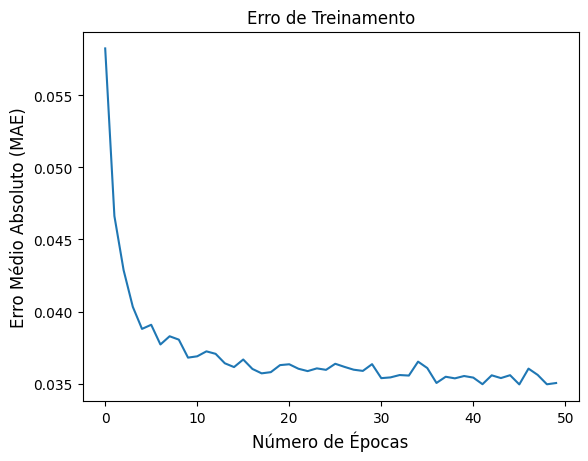

In [ ]:
# Criação da figura e do eixo
fig, ax1 = plt.subplots(1, 1)

# Plotando o histórico de perda do treinamento
ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Erro de Treinamento')

# Verifica se a perda usada no modelo é MAE e ajusta o rótulo do eixo y
if eth_model.loss == 'mae':
    ax1.set_ylabel('Erro Médio Absoluto (MAE)', fontsize=12)
# Caso outro método de perda seja utilizado, exibe como 'Perda do Modelo'
else:
    ax1.set_ylabel('Perda do Modelo', fontsize=12)

# Rótulo do eixo x
ax1.set_xlabel('Número de Épocas', fontsize=12)

# Exibe o gráfico
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


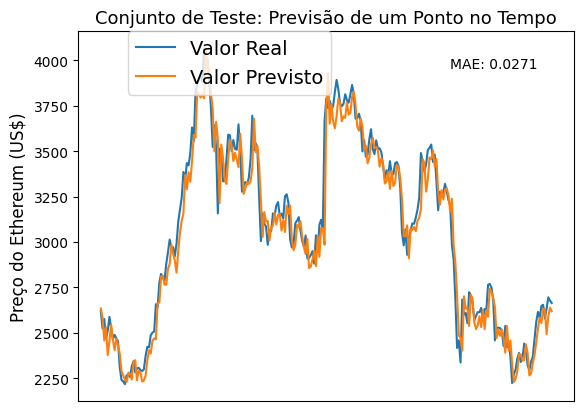

In [ ]:
# Garantindo que a coluna 'Date' esteja no formato datetime
model_data['Date'] = pd.to_datetime(model_data['Date'])

# Criando a figura
fig, ax1 = plt.subplots(1, 1)

# Definindo os rótulos do eixo X
ax1.set_xticks([datetime.date(2020, i+1, 1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2020, i+1, 1).strftime('%b %d %Y') for i in range(12)])

# Plotando os valores reais e previstos no conjunto de teste
ax1.plot(model_data[model_data['Date'] >= split_date]['Date'][window_len:],
         test_set['Close_eth'][window_len:], label='Valor Real')

ax1.plot(model_data[model_data['Date'] >= split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs)) + 1) * test_set['Close_eth'].values[:-window_len])[0],
         label='Valor Previsto')

# Adicionando uma anotação do MAE (Mean Absolute Error)
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs)) + 1) -
             (test_set['Close_eth'].values[window_len:]) / (test_set['Close_eth'].values[:-window_len]))),
             xy=(0.75, 0.9), xycoords='axes fraction',
             xytext=(0.75, 0.9), textcoords='axes fraction')

# Título e rótulo dos eixos
ax1.set_title('Conjunto de Teste: Previsão de um Ponto no Tempo', fontsize=13)
ax1.set_ylabel('Preço do Ethereum (US$)', fontsize=12)

# Exibindo a legenda
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})

# Exibe o gráfico
plt.show()

### Modelo do BTC

In [ ]:
# Inicializando a arquitetura do modelo
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons=20)

# Treinando o modelo nos dados
btc_history = btc_model.fit(
    LSTM_training_inputs,
    (training_set['Close_btc'][window_len:].values / training_set['Close_btc'][:-window_len].values) - 1,
    epochs=50, batch_size=1, verbose=2, shuffle=True
)

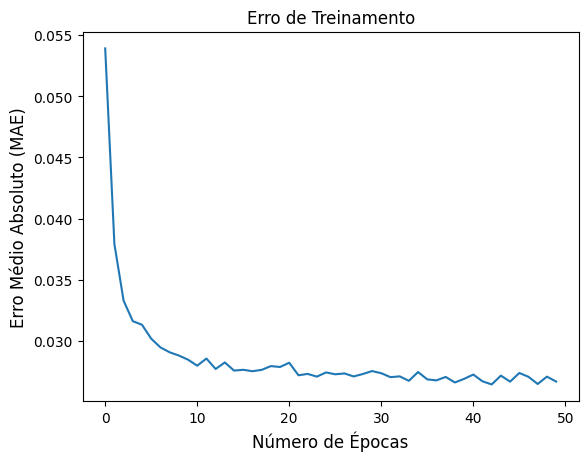

In [ ]:
# Criação da figura e do eixo
fig, ax1 = plt.subplots(1, 1)

# Plotando o histórico de perda do treinamento
ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Erro de Treinamento')

# Verifica se a perda usada no modelo é MAE e ajusta o rótulo do eixo y
if eth_model.loss == 'mae':
    ax1.set_ylabel('Erro Médio Absoluto (MAE)', fontsize=12)
# Caso outro método de perda seja utilizado, exibe como 'Perda do Modelo'
else:
    ax1.set_ylabel('Perda do Modelo', fontsize=12)

# Rótulo do eixo x
ax1.set_xlabel('Número de Épocas', fontsize=12)

# Exibe o gráfico
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


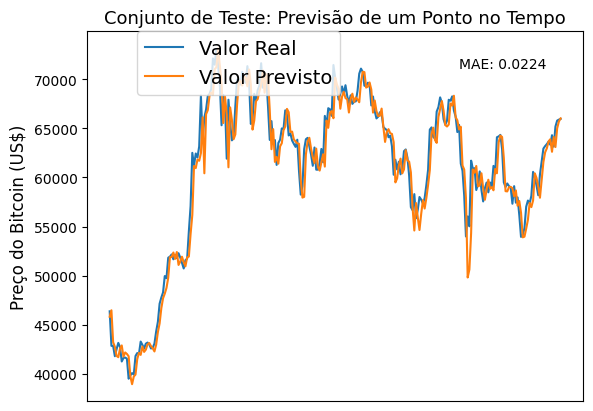

In [ ]:
# Criando a figura para o gráfico
fig, ax1 = plt.subplots(1, 1)

# Definindo os rótulos do eixo X
ax1.set_xticks([datetime.date(2020, i+1, 1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2020, i+1, 1).strftime('%b %d %Y') for i in range(12)])

# Plotando os valores reais e previstos do conjunto de teste
ax1.plot(model_data[model_data['Date'] >= split_date]['Date'][10:],
         test_set['Close_btc'][window_len:], label='Valor Real')

ax1.plot(model_data[model_data['Date'] >= split_date]['Date'][10:],
         ((np.transpose(btc_model.predict(LSTM_test_inputs)) + 1) * test_set['Close_btc'].values[:-window_len])[0],
         label='Valor Previsto')

# Adicionando uma anotação com o MAE (Mean Absolute Error)
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(btc_model.predict(LSTM_test_inputs)) + 1) -
             (test_set['Close_btc'].values[window_len:]) / (test_set['Close_btc'].values[:-window_len]))),
             xy=(0.75, 0.9), xycoords='axes fraction',
             xytext=(0.75, 0.9), textcoords='axes fraction')

# Título e rótulos dos eixos
ax1.set_title('Conjunto de Teste: Previsão de um Ponto no Tempo', fontsize=13)
ax1.set_ylabel('Preço do Bitcoin (US$)', fontsize=12)

# Exibindo a legenda
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})

# Exibe o gráfico
plt.show()

### Avaliação dos Modelos e comparação

In [ ]:
eth_preds = []
btc_preds = []

eth_preds.append(np.mean(abs(np.transpose(eth_model.predict(LSTM_test_inputs))-
            (test_set['Close_eth'].values[window_len:]/test_set['Close_eth'].values[:-window_len]-1))))
btc_preds.append(np.mean(abs(np.transpose(btc_model.predict(LSTM_test_inputs))-
            (test_set['Close_btc'].values[window_len:]/test_set['Close_btc'].values[:-window_len]-1))))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# Calculando a média e o desvio padrão das variações diárias (btc_day_diff) do Bitcoin e Ethereum
btc_r_walk_mean = np.mean(market_df[market_df['Date'] < split_date]['btc_day_diff'].values)
btc_r_walk_sd = np.std(market_df[market_df['Date'] < split_date]['btc_day_diff'].values)

# Gerando os passos aleatórios com base em uma distribuição normal para o Bitcoin
bt_random_steps = np.random.normal(btc_r_walk_mean, btc_r_walk_sd,
                                   (max(market_df['Date']).to_pydatetime() -
                                    datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

eth_r_walk_mean = np.mean(market_df[market_df['Date'] < split_date]['eth_day_diff'].values)
eth_r_walk_sd = np.std(market_df[market_df['Date'] < split_date]['eth_day_diff'].values)

In [ ]:
eth_random_walk_preds = []
btc_random_walk_preds = []

eth_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                    np.array(test_set['Close_eth'][window_len:])/np.array(test_set['Close_eth'][:-window_len]))))
btc_random_walk_preds.append(
np.mean(np.abs((np.random.normal(btc_r_walk_mean, btc_r_walk_sd, len(test_set)-window_len)+1)-
                    np.array(test_set['Close_btc'][window_len:])/np.array(test_set['Close_btc'][:-window_len]))))

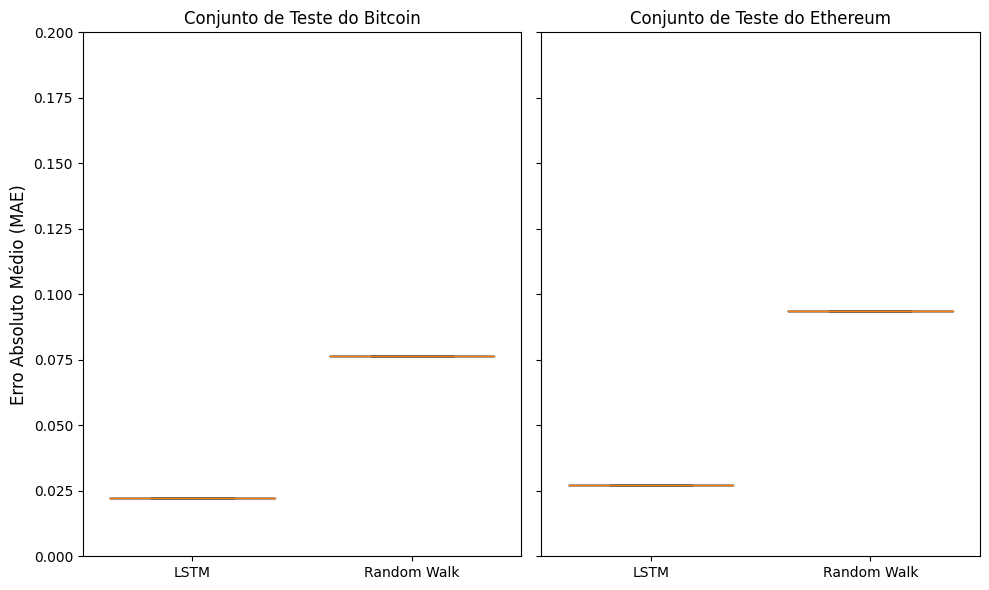

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Gráfico para o Bitcoin
ax1.boxplot([btc_preds, btc_random_walk_preds], widths=0.75)
ax1.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Conjunto de Teste do Bitcoin')
ax1.set_ylabel('Erro Absoluto Médio (MAE)', fontsize=12)

# Gráfico para o Ethereum
ax2.boxplot([eth_preds, eth_random_walk_preds], widths=0.75)
ax2.set_ylim([0, 0.2])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_title('Conjunto de Teste do Ethereum')
ax2.set_yticklabels('')

# Ajuste final e exibição
plt.tight_layout()
plt.show()

## ARIMA

### Dados para teste

In [ ]:
# Seleciona as colunas que vamos usar para previsão
features = ['Open_btc', 'High_btc', 'Low_btc', 'Close_btc', 'Volume_btc',
            'Open_eth', 'High_eth', 'Low_eth', 'Close_eth', 'Volume_eth']

# Normalizando os dados
scaler = MinMaxScaler()
market_df_scaled = scaler.fit_transform(market_df[features])

# Dividindo em treino e teste
train_size = int(len(market_df_scaled) * 0.8)
train_data, test_data = market_df_scaled[:train_size], market_df_scaled[train_size:]

# Separando os conjuntos de entrada (X) e saída (y)
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Definindo o dataset apenas com os preços de fechamento
btc_series = market_df[['Date', 'Close_btc']].set_index('Date')
eth_series = market_df[['Date', 'Close_eth']].set_index('Date')

### Modelo do BTC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


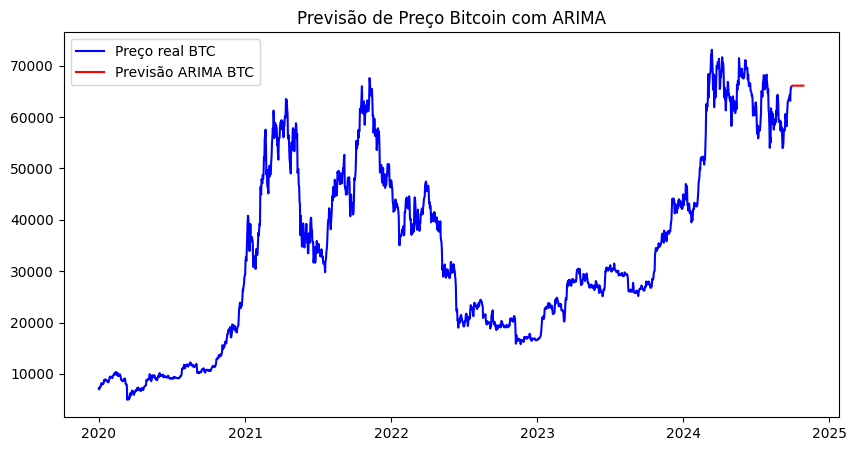

In [ ]:
# BTC

# Definindo o modelo ARIMA para Bitcoin
model_btc = ARIMA(btc_series, order=(5,1,0))
model_btc_fit = model_btc.fit()

# Previsão para o conjunto de teste
forecast_btc = model_btc_fit.forecast(steps=30)  # Prevê os próximos 30 dias

# Visualizando as previsões
plt.figure(figsize=(10,5))
plt.plot(btc_series.index, btc_series['Close_btc'], label="Preço real BTC", color="blue")
plt.plot(pd.date_range(btc_series.index[-1], periods=30, freq='D'), forecast_btc, label="Previsão ARIMA BTC", color="red")
plt.title("Previsão de Preço Bitcoin com ARIMA")
plt.legend()
plt.show()

### Modelo do ETH

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


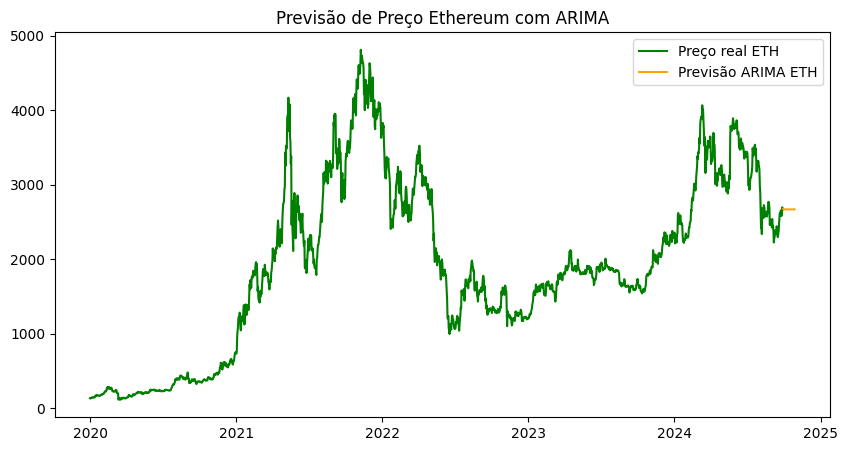

In [ ]:
# ETH

# Definindo o modelo ARIMA para Ethereum
model_eth = ARIMA(eth_series, order=(5,1,0))  # (p=5, d=1, q=0) é um exemplo, ajuste conforme a análise ACF/PACF
model_eth_fit = model_eth.fit()

# Previsão para o conjunto de teste
forecast_eth = model_eth_fit.forecast(steps=30)  # Prevê os próximos 30 dias

# Visualizando as previsões
plt.figure(figsize=(10,5))
plt.plot(eth_series.index, eth_series['Close_eth'], label="Preço real ETH", color="green")
plt.plot(pd.date_range(eth_series.index[-1], periods=30, freq='D'), forecast_eth, label="Previsão ARIMA ETH", color="orange")
plt.title("Previsão de Preço Ethereum com ARIMA")
plt.legend()
plt.show()

### Avaliação dos Modelos

In [ ]:
# Calculando o erro para Bitcoin
btc_test_actual = btc_series['Close_btc'][-30:]  # Últimos 30 dias de dados reais para comparação
mae_btc = mean_absolute_error(btc_test_actual, forecast_btc)
mse_btc = mean_squared_error(btc_test_actual, forecast_btc)
rmse_btc = np.sqrt(mse_btc)

# Calculando o erro para Ethereum
eth_test_actual = eth_series['Close_eth'][-30:]  # Últimos 30 dias de dados reais para comparação
mae_eth = mean_absolute_error(eth_test_actual, forecast_eth)
mse_eth = mean_squared_error(eth_test_actual, forecast_eth)
rmse_eth = np.sqrt(mse_eth)

# Exibindo os resultados
print(f"Bitcoin - MAE: {mae_btc}, MSE: {mse_btc}, RMSE: {rmse_btc}")
print(f"Ethereum - MAE: {mae_eth}, MSE: {mse_eth}, RMSE: {rmse_eth}")

Bitcoin - MAE: 5874.5998706313485, MSE: 47040170.48718219, RMSE: 6858.583708549615
Ethereum - MAE: 206.54662196685337, MSE: 60235.71777774578, RMSE: 245.42965953149545


## Prophet

### Dados para teste

In [ ]:
# Preparando o dataset para o Prophet
btc_prophet_df = btc_series.reset_index().rename(columns={'Date': 'ds', 'Close_btc': 'y'})
eth_prophet_df = eth_series.reset_index().rename(columns={'Date': 'ds', 'Close_eth': 'y'})

Modelo do BTC

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw29wgcxk/jn2kfj2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw29wgcxk/p90kz3n5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69773', 'data', 'file=/tmp/tmpw29wgcxk/jn2kfj2z.json', 'init=/tmp/tmpw29wgcxk/p90kz3n5.json', 'output', 'file=/tmp/tmpw29wgcxk/prophet_modelrvh47q6l/prophet_model-20240929205548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

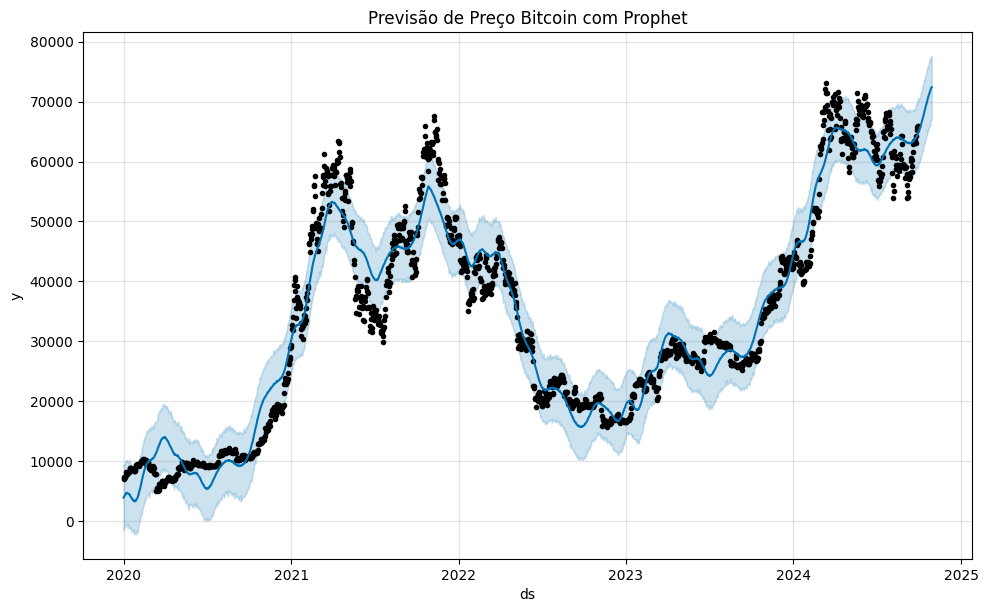

In [ ]:
# Criando e treinando o modelo Prophet para Bitcoin
btc_prophet_model = Prophet()
btc_prophet_model.fit(btc_prophet_df)

# Realizando previsões para os próximos 30 dias
future_btc = btc_prophet_model.make_future_dataframe(periods=30)
forecast_btc = btc_prophet_model.predict(future_btc)

# Plotando as previsões
btc_prophet_model.plot(forecast_btc)
plt.title('Previsão de Preço Bitcoin com Prophet')
plt.show()

### Modelo do ETH

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw29wgcxk/nhkwrsnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw29wgcxk/nfuw66x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50392', 'data', 'file=/tmp/tmpw29wgcxk/nhkwrsnw.json', 'init=/tmp/tmpw29wgcxk/nfuw66x4.json', 'output', 'file=/tmp/tmpw29wgcxk/prophet_modelt694lpb2/prophet_model-20240929205630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

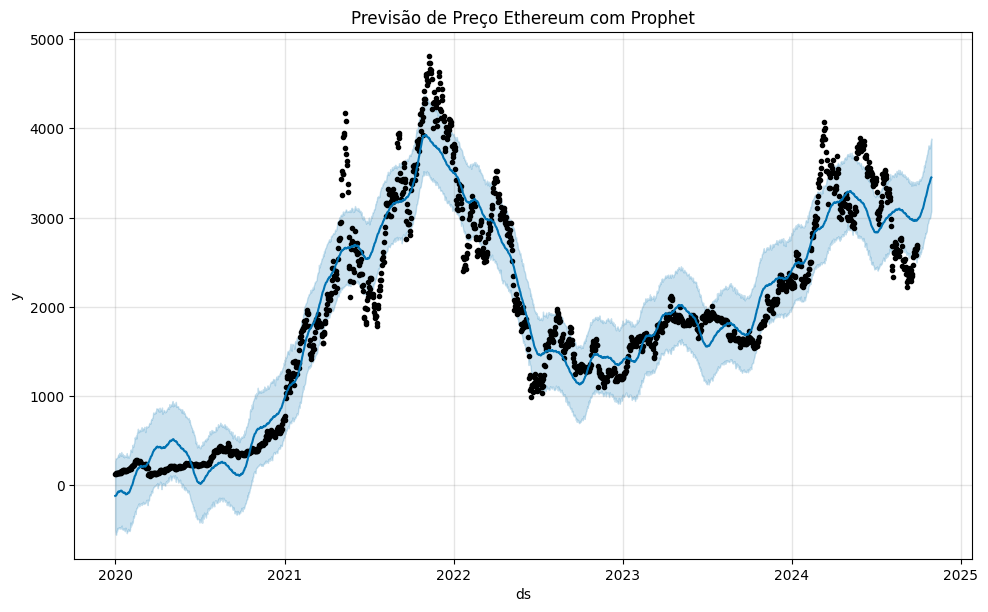

In [ ]:
# Criando e treinando o modelo Prophet para Ethereum
eth_prophet_model = Prophet()
eth_prophet_model.fit(eth_prophet_df)

# Realizando previsões para os próximos 30 dias
future_eth = eth_prophet_model.make_future_dataframe(periods=30)
forecast_eth = eth_prophet_model.predict(future_eth)

# Plotando as previsões
eth_prophet_model.plot(forecast_eth)
plt.title('Previsão de Preço Ethereum com Prophet')
plt.show()

### Avaliação dos Modelos

In [ ]:
# Comparando previsões com dados reais para Bitcoin
btc_test_actual = btc_prophet_df['y'][-30:]
btc_test_pred = forecast_btc['yhat'][-30:]
mae_btc = mean_absolute_error(btc_test_actual, btc_test_pred)
rmse_btc = np.sqrt(mean_squared_error(btc_test_actual, btc_test_pred))

# Comparando previsões com dados reais para Ethereum
eth_test_actual = eth_prophet_df['y'][-30:]
eth_test_pred = forecast_eth['yhat'][-30:]
mae_eth = mean_absolute_error(eth_test_actual, eth_test_pred)
rmse_eth = np.sqrt(mean_squared_error(eth_test_actual, eth_test_pred))

# Exibindo os resultados
print(f"Bitcoin - MAE: {mae_btc}, RMSE: {rmse_btc}")
print(f"Ethereum - MAE: {mae_eth}, RMSE: {rmse_eth}")

Bitcoin - MAE: 8488.359659072661, RMSE: 8684.138721742136
Ethereum - MAE: 729.5828247103566, RMSE: 737.7232262018503


# Conclusão

Após a análise de três modelos temporais —ARIMA, Prophet e LSTM— optou-se pelo uso do modelo **LSTM** devido à sua capacidade superior de modelar dependências temporais de longo prazo em séries temporais complexas, como os preços de criptomoedas. Enquanto o ARIMA e o Prophet demonstram eficácia na captura de padrões sazonais e tendências lineares, ambos enfrentam limitações na modelagem de não linearidades e oscilações rápidas, características comuns em mercados voláteis como o de criptoativos.

O LSTM, por ser uma variação das redes neurais recorrentes (RNNs), oferece uma estrutura projetada para lidar com séries temporais, especialmente em contextos com dados não lineares e voláteis. A arquitetura do LSTM é capaz de preservar informações em longas sequências de dados, superando problemas tradicionais de gradientes desvanecentes que afetam as RNNs tradicionais. Dessa forma, o modelo é capaz de capturar padrões de curto e longo prazo, além de responder adequadamente a mudanças abruptas nos dados, comuns em preços de ativos financeiros.

Portanto, o modelo LSTM se apresenta como a escolha mais adequada devido à sua capacidade de generalização e maior precisão em prever variações complexas e dinâmicas no mercado de criptomoedas.